# Data Cleaning, Feature Engineering, Initial EDA Notebook

In [6]:
# Standard imports
import numpy as np
import pandas as pd

# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Export data
import pickle

# Scotus class object
from scotus_class import scotus

In [2]:
df = pd.read_csv('scotus_rulings.csv', index_col=0)

## Clean data and engineer metric
There are 2 ways shown below on how the case features maybe be engineered/cleaned.  The first treats a case as either a vote with the majority or a dissent.  The second maintains the level of concurrence/dissent of a justice.  In each case, a justice can hold multiple opinions.  They can simultaneously agree with the decision of the majority opinion but hold a separate reasoning(s) on the ruling (filing a concurrence).  With 1 being agreement and 2 filing a concurrence (and similarly 4 being dissent and 3 filing a concurrence/dissent).  The metric used here tries to capture the difference between those opinions by finding the mean of a justice's opinion (while removing filing multiple concurrences/dissents in a specific case).

In [17]:
# Map code string to metric function (binary)
def string_2_ints(s):    
    # Special case 'X' is no vote
    if s is np.nan:
        return np.nan
    if s == 'X':
        return np.nan
    
    # Split and remove non-integers and simplify to either majority or dissent
    nums = []
    for x in set(list(s)):
        try:
            if int(x) > 2: # Any dissent is assigned as dissent against majority opinion
                nums.append(0)
            elif int(x) <= 2:
                nums.append(1)
            elif str(x) == 'nan':
                continue
        except:
            continue

    return nums[0]

# Map code string to metric function (multi-class)
def string_2_multi(s):    
    # Special case 'X' is no vote
    if s is np.nan:
        return np.nan
    if s == 'X':
        return np.nan
    
    # Split and remove non-integers
    nums = []
    for x in set(list(s)):
        try:
            nums.append(int(x))
        except:
            continue
            
    # Return floor of mean value of justices' opinions
    return np.floor(np.mean(nums))

In [18]:
adj_df = pd.DataFrame(np.vectorize(string_2_ints)(df), index=df.index)
mul_df = pd.DataFrame(np.vectorize(string_2_multi)(df), index=df.index)

In [19]:
adj_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647
Alito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Breyer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
Ginsburg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [20]:
mul_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647
Alito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
Breyer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,3.0,1.0,4.0,4.0,4.0
Ginsburg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,3.0,1.0,4.0,4.0,1.0


In [21]:
# Pickle for prediction models
f = open('adj_df.p', 'wb')
pickle.dump(adj_df, f)
f.close()

f = open('mul_df.p', 'wb')
pickle.dump(mul_df, f)
f.close()

## Scotus Rulings Class Object
A class object was created in order to encapsulate data in the file ```scotus_class.py```.  The methods return various forms of data including courts of justices (as old ones retire and new ones are appointed) allowing for easy comparisons for EDA and in a dashboard.

In [ ]:
scotus_obj = scotus(adj_df)

## Initial EDA

### Mean Level of Dissent
Justice's opinions on cases were coded such that:
- 1 = Wrote or Joined Majority
- 2 = Wrote or Joined a Concurrence
- 3 = Wrote or Joined a Concurrence/Dissent
- 4 = Wrote or Joined a Dissent

The graph below illustrates the mean opinion of a justice.  A greater mean opinion equates to a greater tendency to have a differing opinion than the majority opinion.

In [ ]:
fig = px.bar(pd.DataFrame(adj_df.mean(axis=1)).reset_index(), x='index', y=0, range_y=(0, 1))
fig.update_layout(
    title='Justices by Mean Opinion',
    xaxis_title='Justices',
    yaxis_title='Mean Justice Opinion (0=dissent, 1=majority)',
    xaxis={'categoryorder':'total descending'},
)

### Similarity Matrix
The plot below illustrates the cosine similarity between justices

In [ ]:
sim_mat = pd.DataFrame(scotus_obj.sim_matrix(), index=adj_df.index, columns=adj_df.index)

In [ ]:
plt.figure(figsize=(15,10))
mask = np.zeros(sim_mat.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(sim_mat, cmap='coolwarm', mask=mask, square=True)
plt.show()

### Cosine Similarity as a Network Graph

In [ ]:
# Create nodes
nodes = scotus_obj.justices
l = len(nodes)

In [ ]:
# Create edges, tuple = (justice A, justice B, cosine similarity)
edges = []
for i in range(l):
    for j in range(i+1, l):
        if str(sim_mat.iloc[i][j]) != 'nan':
            tup = (sim_mat.iloc[i].name, sim_mat.iloc[i].index[j], sim_mat.iloc[i][j])
            edges.append(tup)

In [ ]:
# Instantiate graph object
fig = plt.figure(figsize=(20,10))
G = nx.Graph()

# Add edges to graph
for edge in edges:
    if edge[2] > 0.65:
        G.add_edge(edge[0], edge[1], weight=edge[2])

# Create line weights
el = [ (u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.95 ]
eml = [ (u, v) for (u, v, d) in G.edges(data=True) if (d['weight'] > 0.9) and (d['weight'] <= 0.95) ]
em = [ (u, v) for (u, v, d) in G.edges(data=True) if (d['weight'] > 0.85) and (d['weight'] <= 0.9) ]

# Postions of nodes and edges
pos = nx.spring_layout(G)
nl = G.nodes(data=True)
nml = G.nodes(data=True)

# Plot Nodes
nx.draw_networkx_nodes(G, pos, node_size=700, alpha=0.8)

# Plot Edges
nx.draw_networkx_edges(G, pos, edgelist=el, width=10, edge_color='r', alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=eml, width=7, edge_color='orange', alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=em, width=4, edge_color='yellow', alpha=0.8)

# Add Justice Labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif')

plt.axis('off')
plt.show()

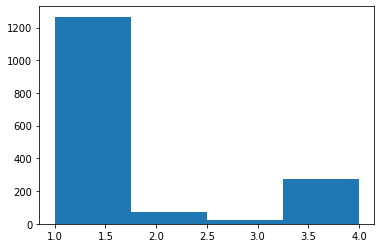

In [26]:
plt.hist(mul_df.loc['Breyer'], bins=4)
plt.show()